<a href="https://colab.research.google.com/github/Evans-tats/CodeAlpha_Emotion-Recognition-from-Speech/blob/main/Emotion_Recognition_from_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Dependencies

- pandas as pd → Data handling, reading CSV files, working with DataFrames

- numpy as np → Numerical operations, arrays, matrix manipulations

- librosa → Audio processing library for loading audio and extracting features (e.g., MFCC, ZCR)

- librosa.display → Utility functions for visualizing audio (waveforms, spectrograms)

- seaborn as sns → Advanced statistical visualizations (e.g., heatmaps, correlation plots)

- matplotlib.pyplot as plt → Basic plotting for data visualization

- sklearn.preprocessing.StandardScaler → Standardize features to have mean=0, variance=1

- sklearn.preprocessing.OneHotEncoder → Convert categorical labels to one-hot encoded vectors

- sklearn.metrics → Tools to evaluate model performance (confusion matrix, classification report)

- sklearn.model_selection.train_test_split → Split dataset into training and testing sets

- IPython.display.Audio → Play audio files directly in notebook cells

- os → Interact with the operating system (file paths, directory handling)



In [1]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio

import os

#Data Loading and Exploration


In [2]:
# Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
#allows direct download of data space to our google colab space
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evanskipsang","key":"ff66d8f0e99e93411cd7356a4a979f33"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 97% 418M/429M [00:00<00:00, 406MB/s]
100% 429M/429M [00:00<00:00, 487MB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d ravdess_data


In [7]:
import os
#initialize lists to store emotion labels and corresponding file paths
file_emotion = []
file_path = []

data_dir = './ravdess_data/'
data = os.listdir(data_dir)#this lists all the subdirectories (actors) in the dataset

for i in data:
    actor_dir = os.path.join(data_dir, i)

    if os.path.isdir(actor_dir):
        actor_files = os.listdir(actor_dir)

        for f in actor_files:
            if f.endswith('.wav'):
                part = f.split('.')[0].split('-')

                if len(part) >= 3:
                    try:
                        emotion_code = int(part[2])
                        file_emotion.append(emotion_code)
                        file_path.append(os.path.join(actor_dir, f))
                    except ValueError:
                        print(f"Skipping file with invalid emotion code: {f}")
                else:
                    print(f"Skipping malformed filename: {f}")


In [8]:
file_path[0]

'./ravdess_data/Actor_17/03-01-04-02-01-01-17.wav'

In [9]:
data_path=pd.DataFrame(file_path,columns=['Path'])
data_path.head()

,Path
0,./ravdess_data/Actor_17/03-01-04-02-01-01-17.wav
1,./ravdess_data/Actor_17/03-01-02-01-02-02-17.wav
2,./ravdess_data/Actor_17/03-01-02-01-01-01-17.wav
3,./ravdess_data/Actor_17/03-01-01-01-02-01-17.wav
4,./ravdess_data/Actor_17/03-01-04-01-01-01-17.wav


In [10]:
print(file_emotion[0])

4


In [11]:
emotion_map = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

emotion_labels = [emotion_map[e] for e in file_emotion]

In [12]:
emotion_labels[0]

'sad'

In [13]:
emotion_df = pd.DataFrame(emotion_labels, columns=['Emotions'])
emotion_df.head()

,Emotions
0,sad
1,calm
2,calm
3,neutral
4,sad


In [14]:
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(Ravdess_df.head())
print("______________________________________________")
print(Ravdess_df.tail())
print("_______________________________________________")
print(Ravdess_df.Emotions.value_counts())

  Emotions                                              Path
0      sad  ./ravdess_data/Actor_17/03-01-04-02-01-01-17.wav
1     calm  ./ravdess_data/Actor_17/03-01-02-01-02-02-17.wav
2     calm  ./ravdess_data/Actor_17/03-01-02-01-01-01-17.wav
3  neutral  ./ravdess_data/Actor_17/03-01-01-01-02-01-17.wav
4      sad  ./ravdess_data/Actor_17/03-01-04-01-01-01-17.wav
______________________________________________
       Emotions                                              Path
1435      angry  ./ravdess_data/Actor_06/03-01-05-01-01-01-06.wav
1436      angry  ./ravdess_data/Actor_06/03-01-05-01-02-02-06.wav
1437  surprised  ./ravdess_data/Actor_06/03-01-08-02-02-01-06.wav
1438    disgust  ./ravdess_data/Actor_06/03-01-07-01-02-01-06.wav
1439       calm  ./ravdess_data/Actor_06/03-01-02-02-02-02-06.wav
_______________________________________________
Emotions
sad          192
calm         192
surprised    192
fearful      192
happy        192
disgust      192
angry        192
neutral       9

/tmp/ipython-input-14-799736559.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


##What is librosa
Librosa is a Python library for audio analysis.

 Load an audio file using librosa.
 librosa.load returns two outputs:
 - 'data': a 1D NumPy array containing the raw audio time series
 - 'sr': the sampling rate (default is 22050 Hz unless specified)
 You can control:
 - 'duration': load only the first 'duration' seconds of audio
- 'offset': skip the first 'offset' seconds before loading
  
  Example: data, sr = librosa.load(path, duration=2.5, offset=0.6)
**bold text**

In [15]:
data ,sr = librosa.load(file_path[0])
sr
# print(data)

22050

In [16]:
ipd.Audio(data,rate=sr)

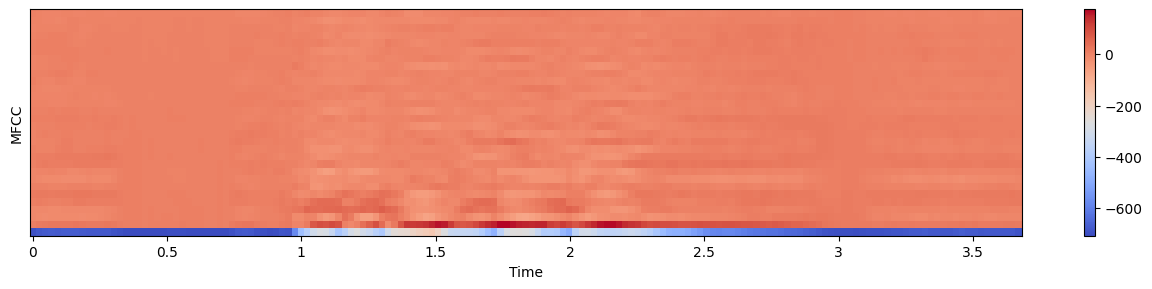

In [17]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

#DATA AUGEMENTATION

- Implement data augmentation techniques (adding noise, shifting, and pitch adjustment) to increase data diversity.

In [18]:
data

array([ 1.1906009e-04,  1.8180301e-04,  7.6198194e-05, ...,
        6.9516682e-05, -1.4928946e-06,  6.7973553e-05], dtype=float32)

In [19]:
#Adds random noise to the input signal
def noise(data):
  # this line # Generate noise amplitude as a small fraction of the maximum signal amplitude
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  # ADD gaussian noise
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  data = np.clip(data, -1.0, 1.0)
  return data

#randomly shifts audio signal either to the left or right in the time axis
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
#changes the pitch of the audio signal
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

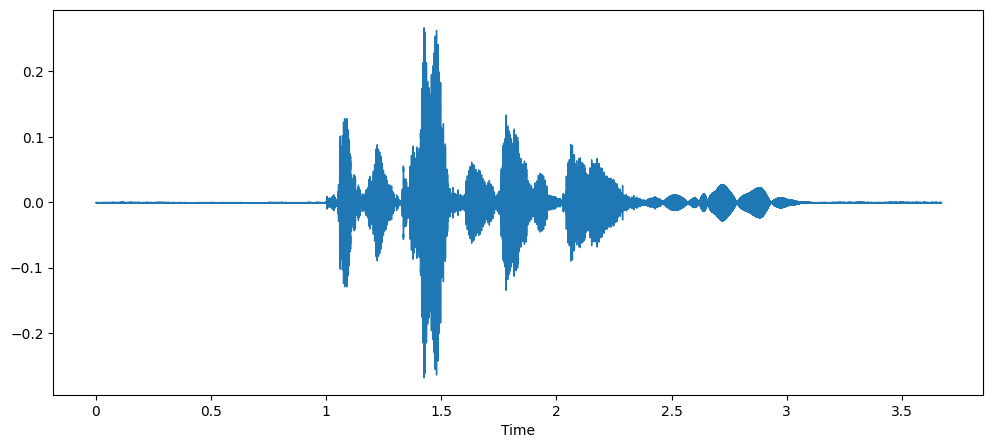

In [20]:
import librosa.display
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=data,sr=sr)
ipd.Audio(data,rate=sr)

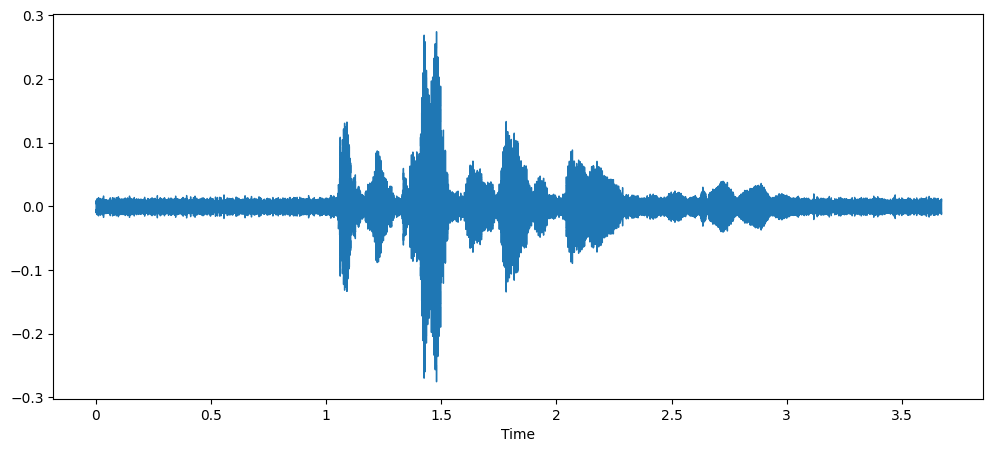

In [21]:
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x,sr=sr)
ipd.Audio(x,rate=sr)

#Feature Extraction (MFCC, ZCR, RMSE)

| Feature                                        | Why It's Useful                                                                                                                          |
| ---------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| **ZCR (Zero Crossing Rate)**                   | Detects signal activity, useful for differentiating sounds like speech vs silence or sharp sounds                                        |
| **RMSE (Energy)**                              | Gives an idea of loudness or intensity, often correlated with emotion (e.g., anger often has higher energy)                              |
| **MFCC (Mel Frequency Cepstral Coefficients)** | Captures the essential characteristics of the speech signal in a way that models human hearing |


In [22]:
#Calculate Zero crossing Rate - rate at which signal crosses the zero amplitude line
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
#calculate Root Mean Square Energy(RMSE) - provides a measure of energy loudness of signal
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
# calculate Mel Frequency Cesptral Coefficients (MFCC) - captures important frequency-based features
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
  result=np.array([])

  result=np.hstack((result,
      zcr(data,frame_length,hop_length),
      rmse(data,frame_length,hop_length),
      mfcc(data,sr,frame_length,hop_length)
    ))

  return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [23]:
import timeit
from tqdm import tqdm

start = timeit.default_timer()
X,Y=[],[]
#loop through each audio file path
for path,emotion,index in tqdm (zip(Ravdess_df.Path,Ravdess_df.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    # loop over each feature set (original + Augementations) and append to list
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

2it [00:01,  1.35it/s]

0 audio has been processed


502it [01:27,  6.22it/s]

500 audio has been processed


1002it [02:49,  6.91it/s]

1000 audio has been processed


1440it [04:01,  5.97it/s]

Done
Time:  241.145749621


In [24]:
len(X), len(Y), data_path.Path.shape

(5760, 5760, (1440,))

##Saving Features
- Save extracted features to a CSV file for future use and to simplify the model training process

In [25]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.060059,0.151367,0.182617,0.260254,0.289551,0.226562,0.256348,0.206055,0.186523,0.225586,...,9.892753,10.038748,10.228060,9.452358,7.383094,5.028688,3.433513,2.475224,1.580086,sad
1,0.256348,0.389648,0.521973,0.523926,0.525391,0.517090,0.506836,0.505371,0.503418,0.492676,...,-1.269840,1.788485,-0.052350,0.704145,0.853125,-0.544993,1.307240,-0.492060,-0.144834,sad
2,0.007812,0.016113,0.041016,0.046875,0.061035,0.077148,0.074707,0.090820,0.111328,0.115723,...,6.955997,7.078037,7.456637,7.189517,6.187727,5.143189,4.398068,3.666671,2.905586,sad
3,0.253906,0.375488,0.498047,0.497559,0.500977,0.496582,0.503906,0.508789,0.498047,0.503906,...,0.440959,-0.322061,0.896955,0.205814,1.645297,1.834477,-3.243343,-1.804359,2.186166,sad
4,0.098633,0.165527,0.181641,0.167969,0.189941,0.180176,0.302246,0.376465,0.375000,0.393066,...,5.852163,5.937589,5.307583,4.264650,2.779260,1.087928,0.057474,0.436954,1.824670,calm


#Data Preprocessing

In [26]:
Emotions = pd.read_csv('./emotion.csv')
Emotions

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.060059,0.151367,0.182617,0.260254,0.289551,0.226562,0.256348,0.206055,0.186523,0.225586,...,9.892753,10.038748,10.228060,9.452358,7.383094,5.028688,3.433513,2.475224,1.580086,sad
1,0.256348,0.389648,0.521973,0.523926,0.525391,0.517090,0.506836,0.505371,0.503418,0.492676,...,-1.269840,1.788485,-0.052350,0.704145,0.853125,-0.544993,1.307240,-0.492060,-0.144834,sad
2,0.007812,0.016113,0.041016,0.046875,0.061035,0.077148,0.074707,0.090820,0.111328,0.115723,...,6.955997,7.078037,7.456637,7.189517,6.187727,5.143189,4.398068,3.666671,2.905586,sad
3,0.253906,0.375488,0.498047,0.497559,0.500977,0.496582,0.503906,0.508789,0.498047,0.503906,...,0.440959,-0.322061,0.896955,0.205814,1.645297,1.834477,-3.243343,-1.804359,2.186166,sad
4,0.098633,0.165527,0.181641,0.167969,0.189941,0.180176,0.302246,0.376465,0.375000,0.393066,...,5.852163,5.937589,5.307583,4.264650,2.779260,1.087928,0.057474,0.436954,1.824670,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,0.255859,0.375977,0.502930,0.494141,0.491699,0.488770,0.482422,0.482422,0.476562,0.483398,...,0.624638,2.145438,2.858443,6.155123,-1.619289,-6.376999,-4.905338,0.569148,0.798853,disgust
5756,0.319824,0.401367,0.496582,0.500977,0.422363,0.468750,0.457520,0.330566,0.299805,0.255371,...,-17.146278,5.976326,9.155354,-8.887676,-2.853044,-0.871931,4.785558,-6.813532,-2.010329,calm
5757,0.259766,0.379395,0.506348,0.499023,0.501465,0.500488,0.505371,0.499023,0.500488,0.509277,...,-4.049881,-1.721359,-1.567860,-5.010232,-4.848533,-4.365362,1.959053,1.853243,-3.438422,calm
5758,0.110840,0.135254,0.173828,0.176758,0.152832,0.188477,0.164062,0.117676,0.104004,0.057617,...,-12.123270,11.058161,3.034128,-13.169507,2.575334,3.721350,0.681608,-14.586863,0.371205,calm


why are there NaN values?

- librosa.feature.mfcc is numerically unstable(log of very small number or negative values)can cause NaNs
- augmentation functions (like noise() or pitch()) might sometimes create invalid audio signals that lead to invalid feature value

all in all NaN values might appear in our feature set. we mitigate thi by makeing their values zero as shown


In [27]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [28]:
Emotions = Emotions.fillna(0)
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


In [29]:
np.sum(Emotions.isna())

,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


In [30]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [31]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [32]:
print(Y.shape)
X.shape

(5760, 8)


(5760, 2376)

In [33]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((4608, 2376), (1152, 2376), (4608, 8), (1152, 8))

We use **StandardScaler** to normalize features so they have zero mean and unit variance, ensuring all features contribute equally during model training.
:

In [34]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

#Model Building

In [35]:
!pip install tensorflow --quite

from tensorflow import keras
# import tensorflow.keras.layers as L

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True )

lr_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


we add one more dimension to our shape as the con1D requires a 3 dimensional data this is:
  (batch_size, sequence_length, num_features)

| **Dimension**     | **Meaning**                                                                  |
| ----------------- | ---------------------------------------------------------------------------- |
| `batch_size`      | Number of samples in each batch (automatically handled during training)      |
| `sequence_length` | Length of the feature vector or number of time steps (e.g., audio frames)    |
| `num_features`    | Number of features per time step (1 for raw features like MFCC, ZCR) |



In [36]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)
x_traincnn.shape, x_testcnn.shape, y_train.shape, y_test.shape

((4608, 2376, 1), (1152, 2376, 1), (4608, 8), (1152, 8))

In [37]:
import tensorflow as tf

In [38]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(128, 5, strides=1,padding='same',activation='relu', input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),#Stabilizes learning, speeds up convergence
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(128, 5,strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2), #Dropout: Prevents overfitting by randomly deactivating neurons during training

    L.Conv1D(64, 5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(64, 5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(32, 5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),

    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(128, activation='relu'),
    L.BatchNormalization(),

    L.Dense(8, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 594, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       307,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465,192 (1.77 MB)

 Trainable params: 464,104 (1.77 MB)

 Non-trainable params: 1,088 (4.25 KB)

#Model Training

In [39]:
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((4608, 2376, 1), (4608, 8), (1152, 2376, 1), (1152, 8))

In [40]:
history=model.fit(x_traincnn,y_train, epochs=15,validation_data=(x_testcnn,y_test),batch_size=32,callbacks=[model_checkpoint,early_stop,lr_reduction])

Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.2972 - loss: 2.0822 - val_accuracy: 0.1441 - val_loss: 3.0325 - learning_rate: 0.0010
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5638 - loss: 1.1936 - val_accuracy: 0.2101 - val_loss: 2.5319 - learning_rate: 0.0010
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.6686 - loss: 0.9475 - val_accuracy: 0.3672 - val_loss: 1.8701 - learning_rate: 0.0010
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.7581 - loss: 0.7102 - val_accuracy: 0.5503 - val_loss: 1.2882 - learning_rate: 0.0010
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8215 - loss: 0.5261 - val_accuracy: 0.7057 - val_loss: 0.9052 - learning_rate: 0.0010
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8825 - loss: 0.3922 - val_accuracy: 0.7526 - val_loss: 0.7312 - learning_rate: 0.0010
Epoch 7/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9119 - loss: 0.

##Model Evaluation

In [42]:
test_loss, test_acc = model.evaluate(x_testcnn, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.8826 - loss: 0.3634
Test Accuracy: 0.88


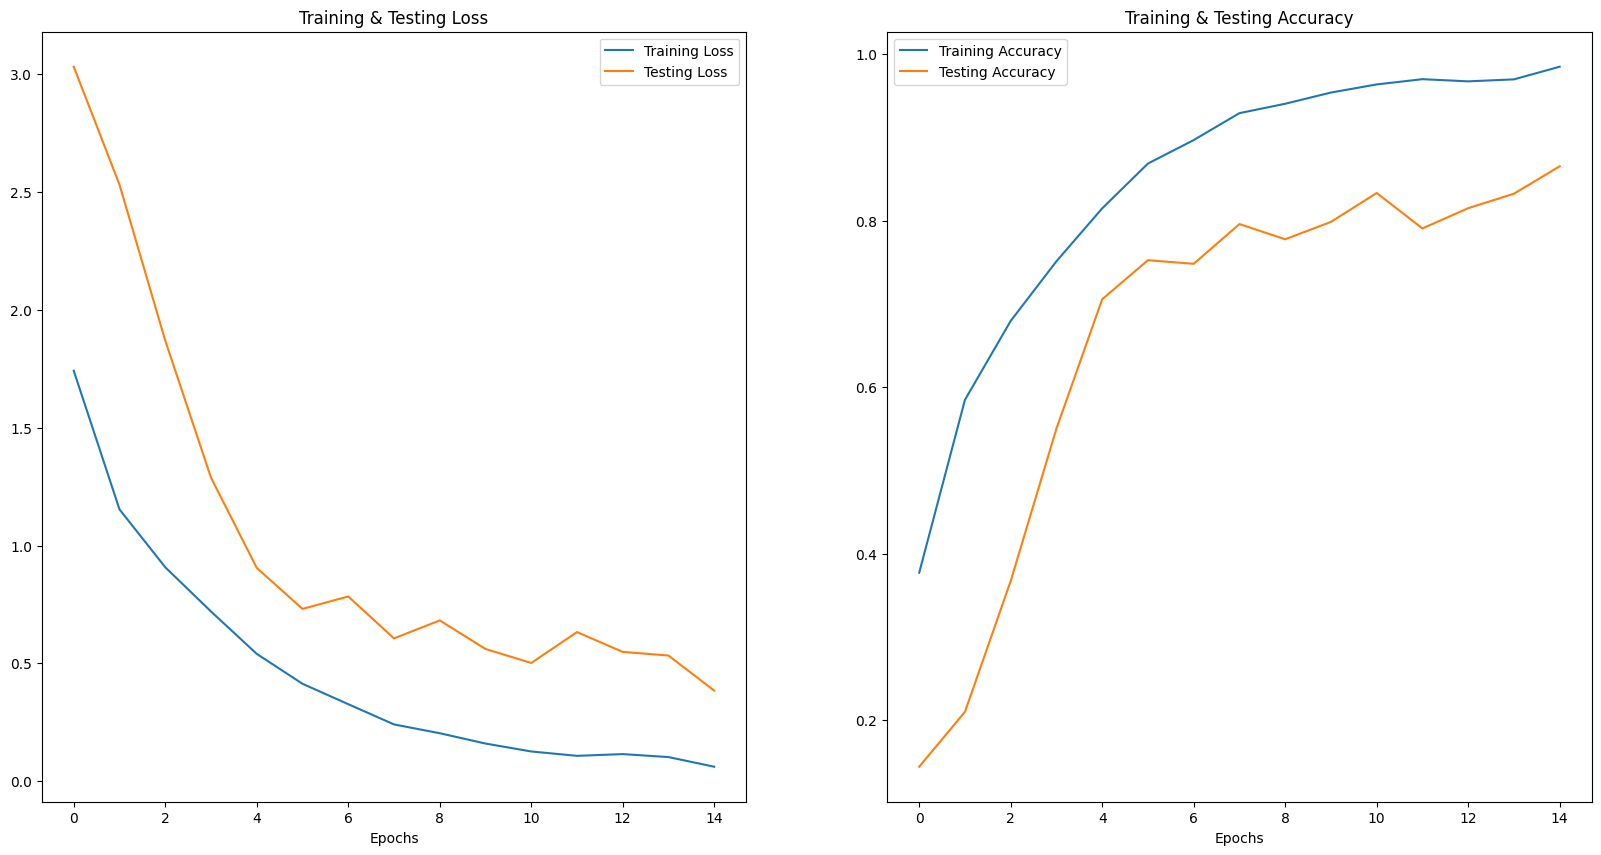

In [46]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss= history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,10)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs, test_loss,label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs, test_acc,label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [48]:
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

df_pred = pd.DataFrame(columns=['Predicted Lables', 'Actual Labels'])
df_pred['Predicted Lables'] = y_pred0.flatten()
df_pred['Actual Labels'] = y_test0.flatten()

df_pred.head(7)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step


,Predicted Lables,Actual Labels
0,calm,calm
1,sad,sad
2,calm,calm
3,fearful,fearful
4,surprised,surprised
5,sad,calm
6,surprised,surprised


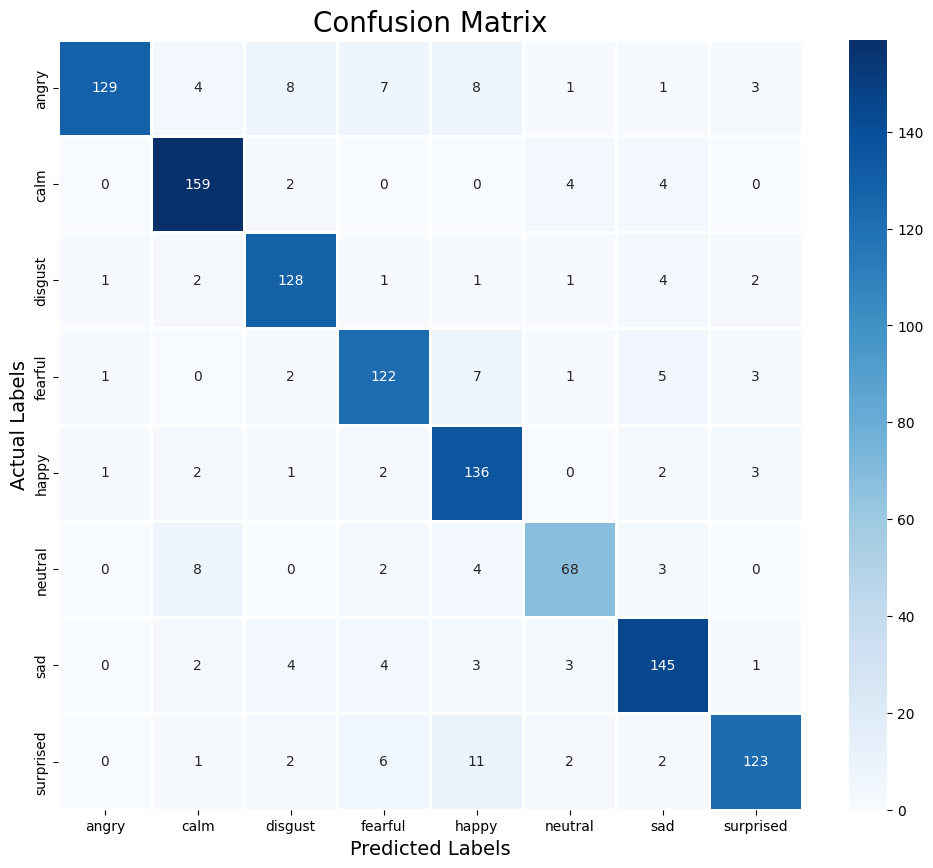

In [53]:
cm = confusion_matrix(y_test0, y_pred0)
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='d')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


#Model & Weight Saving

In [55]:
model.save("model.keras")
print("model saved")

model saved


In [57]:
from tensorflow.keras.models import load_model

loaded_model = load_model("model.keras")

print("model succesfully loaded ")

model succesfully loaded 


In [65]:
scores = loaded_model.evaluate(x_testcnn, y_test)
print("%s : %2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.8826 - loss: 0.3634
compile_metrics : 87.673610%


Saving the Standard Scaler and encoder

In [62]:
!pip install --quiet joblib
import joblib
# Save both together
joblib.dump({'scaler': scaler, 'encoder': encoder}, 'preprocessing.joblib')

# Load both together
preprocessing = joblib.load('preprocessing.joblib')
scaler2 = preprocessing['scaler']
encoder2 = preprocessing['encoder']
